![title](media/DataRobot.png)

### Building a Predictive Model Factory

**Authors**: Thodoris Petropoulos and Matthias Kullowatz

#### Definition

A model factory, in the context of data science, is a system, or a set of procedures that automatically generate predictive models with little or no human intervention. Model factories can have multiple layers of complexity which we can call modules. One module might be training models while other modules could be deploying or retraining the models.

#### Update
In this version of the model factory tutorial, we set up projects and start them in a _parallel_ loop. This allows the user to start all projects simultaneously, and ensure that each has started without unexpected errors, before grabbing their morning coffee. 

### How would you tackle this?

#### - Consider the scenario where you have 20.000 SKUs  and you need to do sales forecasting for each one of them.
#### - Consider the scenario where you have multiple types of customers and you are trying to predict churners.

- Can one model handle the high dimensionality that comes with these problems?
- Is a single model family enough?
- Is one preprocessing method enough?



### Creating a DataRobot Model Factory

In short:
- Use DataRobot to build a single project on the readmissions  dataset.
- Find best model for this project.
- Use DataRobot to build multiple projects based on admission id.
- Find best model for each of the sub-projects
- Make best models ready for deployment

#### Import Libraries

In [11]:
import datarobot as dr #Requires version >2.19
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed, compute #For parallelization
from time import sleep
sns.set(style="whitegrid")

#### Define Functions
Functions that will be used to plot the ROC curve and Feature Impact

In [14]:
def plot_roc_curve(datarobot_model):
    """This function plots a roc curve.
    Input:
        datarobot_model: <Datarobot Model object>
    """
    roc = datarobot_model.get_roc_curve('crossValidation')
    roc_df = pd.DataFrame(roc.roc_points)
    auc_score = datarobot_model.metrics['AUC']['crossValidation']
    plt.plot(roc_df['false_positive_rate'], roc_df['true_positive_rate'], 'b', label = 'AUC = %0.2f' %auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_feature_impact(datarobot_model, title=None):
    """This function plots feature impact
    Input:
        datarobot_model: <Datarobot Model object>
        title : <string> --> title of graph
    """
    #Get feature impact
    feature_impacts = datarobot_model.get_or_request_feature_impact()

    #Sort feature impact based on normalised impact
    feature_impacts.sort(key=lambda x: x['impactNormalized'], reverse=True)

    fi_df = pd.DataFrame(feature_impacts) #Save feature impact in pandas dataframe
    fig, ax = plt.subplots(figsize=(14,5))
    b = sns.barplot(x="featureName", y="impactNormalized", data=fi_df[0:5], color="b")
    b.axes.set_title('Feature Impact' if not title else title,fontsize=20)
    
def wait_for_autopilot(proj, wait=120):
    total_wait = 0
    while proj.get_status()['autopilot_done'] == False:
        sleep(wait)
        total_wait += wait
        total_jobs = len(proj.get_all_jobs())
        print('Autopilot still running! {} jobs running and in queue. Total wait time {}s'.format(total_jobs, total_wait))

In [5]:
#Import dataset
df = pd.read_csv('data/10k_diabetes.csv')

In [6]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis


#### Connect to DataRobot
Connect to DataRobot using your credentials

In [5]:
endpoint = 'YOUR_DATAROBOT_HOST'
api_token = 'YOUR_API_KEY'
dr.Client(token=api_token, endpoint=endpoint)

#### Initiate DataRobot project for all patients

In [15]:
original_proj = dr.Project.start(df,                                       #Pandas dataframe with data
                                project_name = 'Readmissions',             # Name of the project
                                target = 'readmitted',                     #Target of the project
                                metric = 'LogLoss',                        #Optimization metric (Default is LogLoss anyways)
                                worker_count = -1)                         #Amount of workers to use (-1 means every worker available)

log = wait_for_autopilot(original_proj) #Wait for autopilot to finish

Autopilot still running! 23 jobs running and in queue. Total wait time 120s
Autopilot still running! 2 jobs running and in queue. Total wait time 240s
Autopilot still running! 19 jobs running and in queue. Total wait time 360s
Autopilot still running! 2 jobs running and in queue. Total wait time 480s
Autopilot still running! 11 jobs running and in queue. Total wait time 600s
Autopilot still running! 32 jobs running and in queue. Total wait time 720s
Autopilot still running! 4 jobs running and in queue. Total wait time 840s
Autopilot still running! 5 jobs running and in queue. Total wait time 960s
Autopilot still running! 4 jobs running and in queue. Total wait time 1080s
Autopilot still running! 1 jobs running and in queue. Total wait time 1200s
Autopilot still running! 3 jobs running and in queue. Total wait time 1320s
Autopilot still running! 4 jobs running and in queue. Total wait time 1440s
Autopilot still running! 4 jobs running and in queue. Total wait time 1560s
Autopilot still 

#### Get best model from original project

In [16]:
#Pick best model
best_model = original_proj.get_models()[0]

print(best_model) #Print best model's name
best_model.metrics['LogLoss']['crossValidation'] #Print crossValidation score

Model('Advanced AVG Blender')


0.607342

#### Visualize the ROC Curve

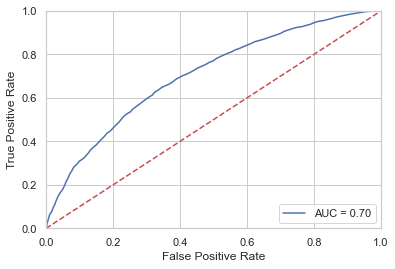

In [8]:
plot_roc_curve(best_model)

#### Plotting Feature Impact

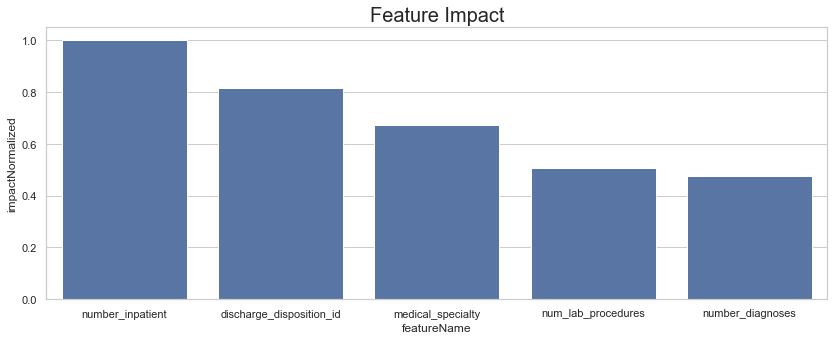

In [9]:
plot_feature_impact(best_model)

#### Making a better model
Admission type can be used as a splitting point in order to create multiple projects.

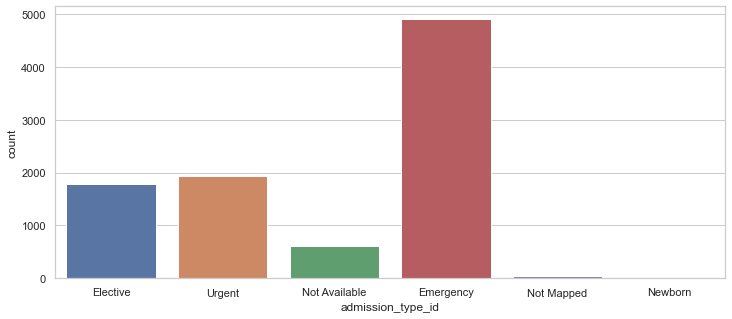

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
c = sns.countplot(x="admission_type_id",data=df)

#### Creating a mini model factory
In the original version of this tutorial, we showed how to use a simple "for" loop to set up multiple projects. In some cases, often when DataRobot needs to set up automated feature discovery (AFD), it may take a while to perform the Exploratory Data Analysis (EDA) steps. In these cases, it may be more convenient to kick off all the projects simultaneously, i.e., in parallel. Here we use Python's dask module to do just that.

In [17]:
def run_dr_factory(segment_num):
    try:
        temp_project = dr.Project.start(df.loc[df['admission_type_id'] == segment_num],
                                    project_name = 'Readmission_%s'%segment_num,
                                    target = 'readmitted',
                                    metric = 'LogLoss',
                                    worker_count = 10)
        return temp_project
    except: #Catching the case when dataset has fewer than 20 rows.
        return f"There was an error in segment {segment_num}."


In [ ]:
delayed_dr_projects = []

#Create one project for each customer type
for value in df['admission_type_id'].unique():
    temp = delayed(run_dr_factory)(value)
    delayed_dr_projects.append(temp)

projects = compute(delayed_dr_projects)[0]
#Filter to the projects that did not throw errors
projects_filtered = [project for project in projects if not isinstance(project, str)]

#### Getting best model for each customer category

In [33]:
best_models = {} #To save models
for key, project in enumerate(projects_filtered):
    best_models[key] = projects_filtered[key].get_models()[0]
    print('--------------------------------')
    print('Best model for admission type id: %s' % project)
    print(best_models[key])
    print(best_models[key].metrics['LogLoss']['crossValidation'])
    print('--------------------------------')

--------------------------------
Best model for admission type id: Project(Readmission_Elective)
Model('Nystroem Kernel SVM Classifier')
0.616634
--------------------------------
--------------------------------
Best model for admission type id: Project(Readmission_Urgent)
Model('eXtreme Gradient Boosted Trees Classifier with Unsupervised Learning Features')
0.5905380000000001
--------------------------------
--------------------------------
Best model for admission type id: Project(Readmission_Not Available)
Model('Eureqa Generalized Additive Model Classifier (1000 Generations)')
0.626658
--------------------------------
--------------------------------
Best model for admission type id: Project(Readmission_Emergency)
Model('Advanced AVG Blender')
0.623124
--------------------------------


##### Even though accuracy changes might be insignificant for this dataset, in cases where it makes sense, model factory can produce measurable value. Furthermore, this concept becomes more and more important the higher the cardinality of your data.

#### Its not just about more predictive performance....
We also have differences in feature impact which could give actionable insights.

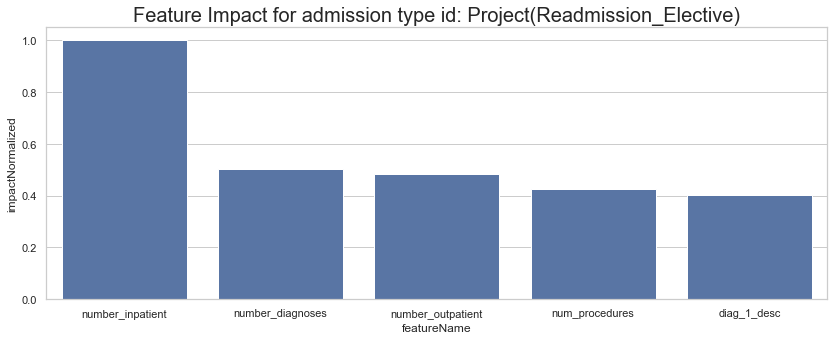

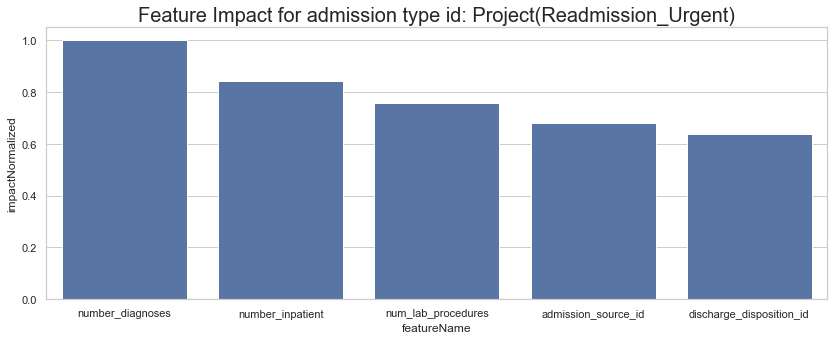

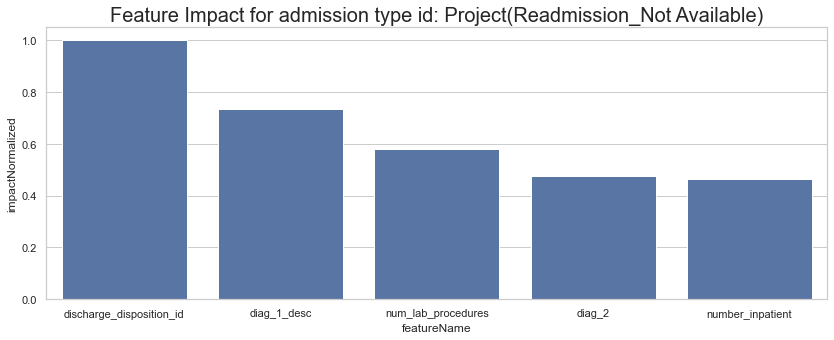

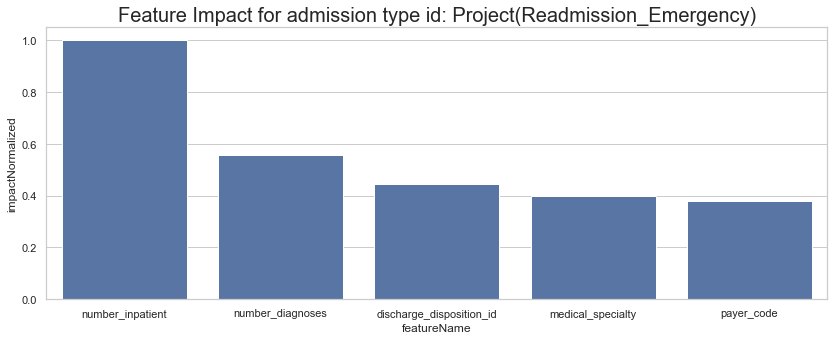

In [35]:
for key, project in enumerate(projects_filtered):
    plot_feature_impact(best_models[key], title ='Feature Impact for admission type id: %s' % project)

#### Deploying the models
Deploy the models as a REST API after which, we can make HTTP requests and get predictions back by using the deployment id!

In [44]:
prediction_server = dr.PredictionServer.list()[0]

for key in best_models:
    temp_deployment = dr.Deployment.create_from_learning_model(
                                    best_models[key].id, label='Readmissions_admission_type: %s' %key,
                                    description='Test deployment',
                                    default_prediction_server_id=prediction_server.id
                                            )

#### Through the API, the sky is the limit when it comes to what you can do: 

- You could monitor service performance (also available via UI)
- You could motior accuracy performance (also available via UI)
- You could retrain and update models (also available via UI)

You could create a model factory that does all of the above based on rules you set and need minimum human intervention. 